In [1]:
import numpy as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [36]:
%run reg_utils.ipynb

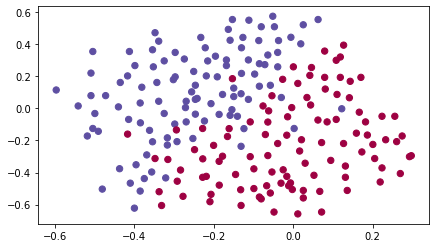

In [5]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

# Model

In [6]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    costs = []
    grads = {}
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            A3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            A3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
            
        # Cost function:
        if lambd == 0:
            cost = compute_cost(A3, Y)
        else:
            cost = compute_cost_with_regularization(A3, Y, parameters, lambd)
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print('Cost after iteration {} : {}'.format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    # Plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iteration (1000)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    
    return parameters

# L2 - regularization

In [7]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    crossentropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = lambd/m/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))  
    cost = crossentropy_cost + L2_regularization_cost
    
    return cost

In [8]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    grads = {}
    
    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T) + lambd/m * W3
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0)) # dao ham ReLU: g'(z) = 1 if z >=0
    dW2 = 1/m * np.dot(dZ2, A1.T) + lambd/m * W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1/m * np.dot(dZ1, X.T) + lambd/m * W1
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
            "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
            "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return grads

# Dropout

In [11]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    # LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0],A1.shape[1])     # Khởi tạo ngẫu nhiên ma trận D
    D1 = D1<keep_prob                                # Chuyển D về 0 và 1 thông qua threshold
    A1 = np.multiply(A1, D1)                         # Shut down noron của A
    A1 = A1/keep_prob                                # Trả lại giá trị của noron không bị shut down
    
    Z2 = np.dot(parameters['W2'], A1) + parameters['b2']
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = D2<keep_prob
    A2 = np.multiply(A2, D2)
    A2 = A2/keep_prob
    
    Z3 = np.dot(parameters['W3'], A2) + parameters['b3']
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [43]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    grads = {}
    
    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2, D2)
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0)) # dao ham ReLU: g'(z) = 1 if z >=0
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1, D1)
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
            "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
            "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return grads

# So sánh 3 mô hình

## Non regularization

Cost after iteration 0 : 0.8674883984557835
Cost after iteration 10000 : 0.14869346996677793
Cost after iteration 20000 : 0.12278154449346944


<ipython-input-33-d8d57e4e80b5>:4: RuntimeWarning: divide by zero encountered in log
  cost = -1/m * np.nansum(np.multiply(Y, np.log(A3)) + np.multiply(1 - Y, np.log(1 - A3)))
<ipython-input-33-d8d57e4e80b5>:4: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m * np.nansum(np.multiply(Y, np.log(A3)) + np.multiply(1 - Y, np.log(1 - A3)))


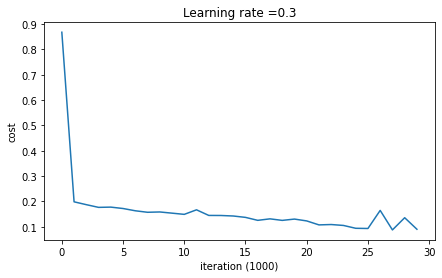

On the training set:
Accuracy: 0.976303317535545
On the test set:
Accuracy: 0.935


In [34]:
parameters1 = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters1)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters1)

<ipython-input-36-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


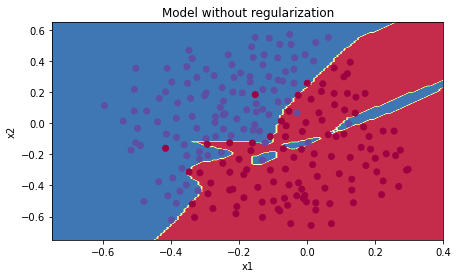

In [37]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters1, x.T), train_X, train_Y)

Cost after iteration 0 : 1.9896742522034885
Cost after iteration 10000 : 0.2687743193872809
Cost after iteration 20000 : 0.26855516618421826


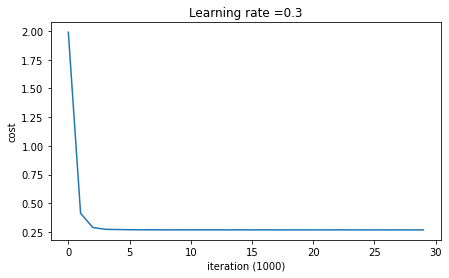

On the training set:
Accuracy: 0.933649289099526
On the test set:
Accuracy: 0.92


In [38]:
parameters2 = model(train_X, train_Y, lambd = 0.7)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters2)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters2)

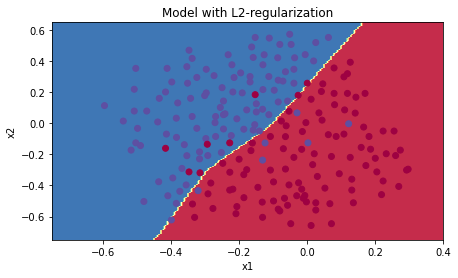

In [39]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters2, x.T), train_X, train_Y)

Cost after iteration 0 : 2.7564506289134028


<ipython-input-36-d8d57e4e80b5>:4: RuntimeWarning: divide by zero encountered in log
  cost = -1/m * np.nansum(np.multiply(Y, np.log(A3)) + np.multiply(1 - Y, np.log(1 - A3)))
<ipython-input-36-d8d57e4e80b5>:4: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m * np.nansum(np.multiply(Y, np.log(A3)) + np.multiply(1 - Y, np.log(1 - A3)))


Cost after iteration 10000 : 0.19499385906395394
Cost after iteration 20000 : 0.2210329012465173


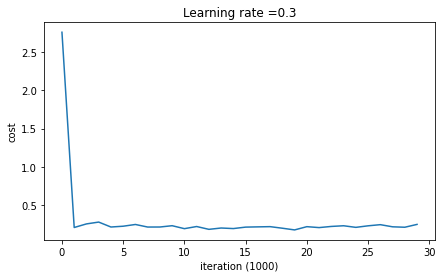

On the train set:
Accuracy: 0.95260663507109
On the test set:
Accuracy: 0.96


In [44]:
parameters3 = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters3)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters3)

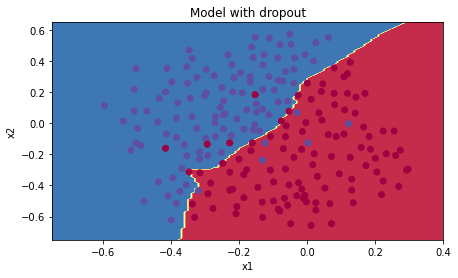

In [45]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters3, x.T), train_X, train_Y)

# Nhận xét
Ban đầu khi không sử dụng regularization hoặc dropout thì model bị overfitting.
Sau khi áp dụng L2 regularization hoặc dropout thì model đã cho kết quả tốt hơn và không còn bị overfitting nữa.